In [1]:
import pandas as pd
import numpy as np
import os,cv2
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import tensorflow as tf
from tensorflow import keras
from IPython.display import SVG
import pydot
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Sequential, Model
from keras.initializers import *

In [2]:
datasets = ["./data/plant-seedlings-classification/train"]

class_names = ["Black-grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-flowered Cranesbill","Sugar beet"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

nb_classes = len(class_names)
class_name_labels

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

Loading the train data into 2 lists *images* and *labels*, each storing the image and its corresponding labels. The labels in this case are the type of seedlings as recorded in the dataset.

In [3]:
from tqdm import tqdm

def load_data():
    images,labels = [],[]
    for dataset in datasets:

        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                
                img_path = os.path.join(os.path.join(dataset,folder),file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img,(150,150))
                
                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)
        labels = np.array(labels,dtype=np.float32)
        
        pass
    
    return images,labels
    pass

In [4]:
(train_images),(train_labels) = load_data()

100%|████████████████████████████████████████████████████████████████████████████████| 385/385 [00:04<00:00, 85.33it/s]


Counting the number of images associated with each label.

In [5]:
n_train = train_labels.shape[0]

_, train_count = np.unique(train_labels,return_counts=True)

df = pd.DataFrame(data = train_count)
# df = df.T
df['Index'] = class_names
df.columns = ['Train','Name']
df

,Train,Name
0,263,Black-grass
1,390,Charlock
2,287,Cleavers
3,611,Common Chickweed
4,221,Common wheat
5,475,Fat Hen
6,654,Loose Silky-bent
7,221,Maize
8,516,Scentless Mayweed
9,231,Shepherds Purse


In [6]:
def show_final_history(history):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title("Loss")
    ax[1].set_title("Accuracy")
    ax[0].plot(history.history["loss"],label="Loss")
    ax[0].plot(history.history["val_loss"],label="Test Loss")
    ax[1].plot(history.history["accuracy"],label="Accuracy")
    ax[1].plot(history.history["val_accuracy"],label="Test Accuracy")
    
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="lower right")

In [7]:
train_labels

array([ 0.,  0.,  0., ..., 11., 11., 11.], dtype=float32)

In [8]:
train_labels = to_categorical(train_labels,num_classes=nb_classes)

In [9]:
train_labels.shape

(4750, 12)

In [10]:
X_train,X_val,y_train,y_val = train_test_split(train_images,train_labels,test_size=0.3)

In [11]:
train_dir = "./data/plant-seedlings-classification/train"

batch_size = 16

IGD = ImageDataGenerator(rescale=1./255,
                        horizontal_flip=True,
                        vertical_flip=True,
                        rotation_range=20)
#                         validation_split=0.3)

train_generator = IGD.flow(x=X_train,
                          y=y_train,
                          batch_size=batch_size,
                          shuffle=True,
                          seed=42)
#                           subset="training")

validation_generator = IGD.flow(x=X_val,
                               y=y_val,
                               batch_size=batch_size,
                               shuffle=True,
                               seed=42)
#                                subset="validation")

In [12]:
def conv_block(X,k,filters,stage,block,s=2):
    
    conv_base_name = 'res_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + "_branch"
    
    F1 = filters
    
    X = Conv2D(filters=F1,kernel_size=(k,k),strides=(s,s),
              padding='same',name=conv_base_name,
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_base_name)(X)
#     X = MaxPooling2D((3,3))(X)
    X = Activation('relu')(X)
    
    return X
    pass

In [13]:
def conv_model(input_shape,classes):
    
    X_input = Input(input_shape)
    
    # Stage 1
    X = Conv2D(64,(5,5),strides=(2,2),name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
#     X = MaxPooling2D((3,3))(X)
#     X = Activation('relu')(X)
#     X = Dropout(0.1)(X)
    
    # Stage 2
    X = conv_block(X,5,64,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.1)(X)
    
    # Stage 3 
    X = conv_block(X,3,128,3,block='A',s=1)
    X = MaxPooling2D((3,3))(X)
    X = Dropout(0.1)(X)
    
    # Stage 4
    X = conv_block(X,5,256,4,block='A',s=1)
    X = Dropout(0.1)(X)
    
    # Output Layer
    X = Flatten()(X)
    X = Dense(256)(X)
    X = Dense(256)(X)
    X = Activation('relu')(X)
    X = Dense(classes,activation='softmax',name='fc'+str(classes))(X)
    
    model = Model(inputs=X_input,outputs=X,name='CNN')
    
    return model
    pass

In [14]:
model = conv_model(input_shape=(150,150,3),classes=nb_classes)

Saving the model architecture as a flowchart for better understanding to *`conv_model.png`*

In [15]:
import pydot

In [16]:
plot_model(model,to_file='conv_model.png')
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 73, 73, 64)        4864      
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 73, 73, 64)       256       
 n)                                                              
                                                                 
 res_2A_branch (Conv2D)      (None, 73, 73, 64)        102464    
                                                                 
 bn_2A_branch (BatchNormaliz  (None, 73, 73, 64)       256       
 ation)                                                          
                                                                 
 activation (Activation)     (None, 73, 73, 64)        0       

Using the Adam optimiser with learning rate set at 0.001 as this is currently giving the most optimal model.

In [17]:
opt = Adam(lr=0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

C:\Users\soumi\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Storing the model's weights to *`model_weights.h5`*. This stores the best weights possible.

In [18]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,
                             save_best_only=True,mode="max")
callbacks_list = [checkpoint]

Running the model for 50 epochs

In [19]:
import scipy

In [20]:
epochs = 500

history = model.fit(train_generator,
                              steps_per_epoch=train_generator.n//batch_size,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.n//batch_size,
                              callbacks=callbacks_list,
                              verbose=1)

Epoch 1/500
207/207 [==============================] - ETA: 0s - loss: 1.8813 - accuracy: 0.4170
Epoch 1: val_accuracy improved from -inf to 0.13272, saving model to model_weights.h5
207/207 [==============================] - 29s 98ms/step - loss: 1.8813 - accuracy: 0.4170 - val_loss: 8.8851 - val_accuracy: 0.1327
Epoch 2/500
207/207 [==============================] - ETA: 0s - loss: 1.1724 - accuracy: 0.6150
Epoch 2: val_accuracy improved from 0.13272 to 0.13343, saving model to model_weights.h5
207/207 [==============================] - 20s 94ms/step - loss: 1.1724 - accuracy: 0.6150 - val_loss: 8.1862 - val_accuracy: 0.1334
Epoch 3/500
207/207 [==============================] - ETA: 0s - loss: 0.9259 - accuracy: 0.7084
Epoch 3: val_accuracy improved from 0.13343 to 0.54705, saving model to model_weights.h5
207/207 [==============================] - 20s 98ms/step - loss: 0.9259 - accuracy: 0.7084 - val_loss: 1.3829 - val_accuracy: 0.5471
Epoch 4/500
207/207 [=========================

Epoch 29/500
207/207 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.9096
Epoch 29: val_accuracy did not improve from 0.88343
207/207 [==============================] - 24s 115ms/step - loss: 0.2442 - accuracy: 0.9096 - val_loss: 0.9727 - val_accuracy: 0.7542
Epoch 30/500
207/207 [==============================] - ETA: 0s - loss: 0.2887 - accuracy: 0.9021
Epoch 30: val_accuracy did not improve from 0.88343
207/207 [==============================] - 24s 116ms/step - loss: 0.2887 - accuracy: 0.9021 - val_loss: 0.9156 - val_accuracy: 0.7816
Epoch 31/500
207/207 [==============================] - ETA: 0s - loss: 0.2344 - accuracy: 0.9211
Epoch 31: val_accuracy did not improve from 0.88343
207/207 [==============================] - 24s 116ms/step - loss: 0.2344 - accuracy: 0.9211 - val_loss: 0.5988 - val_accuracy: 0.8272
Epoch 32/500
207/207 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.9130
Epoch 32: val_accuracy did not improve from 0.8834

207/207 [==============================] - 24s 118ms/step - loss: 0.1245 - accuracy: 0.9541 - val_loss: 0.7172 - val_accuracy: 0.8315
Epoch 58/500
207/207 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9547
Epoch 58: val_accuracy did not improve from 0.90239
207/207 [==============================] - 24s 118ms/step - loss: 0.1282 - accuracy: 0.9547 - val_loss: 0.4979 - val_accuracy: 0.8834
Epoch 59/500
207/207 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9529
Epoch 59: val_accuracy did not improve from 0.90239
207/207 [==============================] - 24s 118ms/step - loss: 0.1406 - accuracy: 0.9529 - val_loss: 1.4227 - val_accuracy: 0.7549
Epoch 60/500
207/207 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9571
Epoch 60: val_accuracy did not improve from 0.90239
207/207 [==============================] - 24s 117ms/step - loss: 0.1289 - accuracy: 0.9571 - val_loss: 0.4988 - val_accuracy: 0.8926
Epoch 61/500
2

207/207 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9625
Epoch 86: val_accuracy did not improve from 0.90379
207/207 [==============================] - 24s 118ms/step - loss: 0.1232 - accuracy: 0.9625 - val_loss: 0.9505 - val_accuracy: 0.8265
Epoch 87/500
207/207 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9689
Epoch 87: val_accuracy did not improve from 0.90379
207/207 [==============================] - 24s 118ms/step - loss: 0.0882 - accuracy: 0.9689 - val_loss: 0.6524 - val_accuracy: 0.8624
Epoch 88/500
207/207 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9716
Epoch 88: val_accuracy did not improve from 0.90379
207/207 [==============================] - 24s 117ms/step - loss: 0.0834 - accuracy: 0.9716 - val_loss: 0.4455 - val_accuracy: 0.8968
Epoch 89/500
207/207 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9743
Epoch 89: val_accuracy improved from 0.90379 to 0.92205, saving

Epoch 115/500
207/207 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9716
Epoch 115: val_accuracy did not improve from 0.92205
207/207 [==============================] - 24s 117ms/step - loss: 0.1070 - accuracy: 0.9716 - val_loss: 1.0471 - val_accuracy: 0.7985
Epoch 116/500
207/207 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9749
Epoch 116: val_accuracy did not improve from 0.92205
207/207 [==============================] - 25s 119ms/step - loss: 0.0843 - accuracy: 0.9749 - val_loss: 0.6364 - val_accuracy: 0.8743
Epoch 117/500
207/207 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9740
Epoch 117: val_accuracy did not improve from 0.92205
207/207 [==============================] - 24s 118ms/step - loss: 0.0852 - accuracy: 0.9740 - val_loss: 1.0330 - val_accuracy: 0.8350
Epoch 118/500
207/207 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9764
Epoch 118: val_accuracy did not improve fro

Epoch 144/500
207/207 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9834
Epoch 144: val_accuracy did not improve from 0.92205
207/207 [==============================] - 24s 117ms/step - loss: 0.0519 - accuracy: 0.9834 - val_loss: 0.4593 - val_accuracy: 0.9038
Epoch 145/500
207/207 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9804
Epoch 145: val_accuracy did not improve from 0.92205
207/207 [==============================] - 24s 117ms/step - loss: 0.0696 - accuracy: 0.9804 - val_loss: 1.3133 - val_accuracy: 0.8090
Epoch 146/500
207/207 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9834
Epoch 146: val_accuracy did not improve from 0.92205
207/207 [==============================] - 24s 117ms/step - loss: 0.0611 - accuracy: 0.9834 - val_loss: 0.6756 - val_accuracy: 0.8722
Epoch 147/500
207/207 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9834
Epoch 147: val_accuracy did not improve fro

Epoch 173/500
207/207 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.9894
Epoch 173: val_accuracy did not improve from 0.92205
207/207 [==============================] - 25s 118ms/step - loss: 0.0229 - accuracy: 0.9894 - val_loss: 0.4523 - val_accuracy: 0.9206
Epoch 174/500
207/207 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9885
Epoch 174: val_accuracy did not improve from 0.92205
207/207 [==============================] - 24s 117ms/step - loss: 0.0379 - accuracy: 0.9885 - val_loss: 0.5084 - val_accuracy: 0.9073
Epoch 175/500
207/207 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9807
Epoch 175: val_accuracy did not improve from 0.92205
207/207 [==============================] - 24s 117ms/step - loss: 0.0555 - accuracy: 0.9807 - val_loss: 0.6316 - val_accuracy: 0.8982
Epoch 176/500
207/207 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9873
Epoch 176: val_accuracy did not improve fro

Epoch 202/500
207/207 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9888
Epoch 202: val_accuracy did not improve from 0.92205
207/207 [==============================] - 25s 118ms/step - loss: 0.0382 - accuracy: 0.9888 - val_loss: 5.8406 - val_accuracy: 0.5723
Epoch 203/500
207/207 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9785
Epoch 203: val_accuracy did not improve from 0.92205
207/207 [==============================] - 25s 118ms/step - loss: 0.0827 - accuracy: 0.9785 - val_loss: 3.7944 - val_accuracy: 0.6103
Epoch 204/500
207/207 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9837
Epoch 204: val_accuracy did not improve from 0.92205
207/207 [==============================] - 25s 119ms/step - loss: 0.0582 - accuracy: 0.9837 - val_loss: 0.5165 - val_accuracy: 0.9122
Epoch 205/500
207/207 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9903
Epoch 205: val_accuracy did not improve fro

207/207 [==============================] - 24s 117ms/step - loss: 0.0302 - accuracy: 0.9897 - val_loss: 0.7710 - val_accuracy: 0.8897
Epoch 231/500
207/207 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9958
Epoch 231: val_accuracy improved from 0.92346 to 0.92556, saving model to model_weights.h5
207/207 [==============================] - 25s 119ms/step - loss: 0.0170 - accuracy: 0.9958 - val_loss: 0.4487 - val_accuracy: 0.9256
Epoch 232/500
207/207 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9958
Epoch 232: val_accuracy did not improve from 0.92556
207/207 [==============================] - 25s 118ms/step - loss: 0.0152 - accuracy: 0.9958 - val_loss: 0.5212 - val_accuracy: 0.9213
Epoch 233/500
207/207 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9958
Epoch 233: val_accuracy did not improve from 0.92556
207/207 [==============================] - 25s 118ms/step - loss: 0.0150 - accuracy: 0.9958 - val_loss: 

207/207 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9879
Epoch 259: val_accuracy did not improve from 0.92556
207/207 [==============================] - 24s 117ms/step - loss: 0.0475 - accuracy: 0.9879 - val_loss: 0.6380 - val_accuracy: 0.9031
Epoch 260/500
207/207 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9918
Epoch 260: val_accuracy did not improve from 0.92556
207/207 [==============================] - 24s 118ms/step - loss: 0.0305 - accuracy: 0.9918 - val_loss: 0.5421 - val_accuracy: 0.9150
Epoch 261/500
207/207 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9930
Epoch 261: val_accuracy did not improve from 0.92556
207/207 [==============================] - 24s 118ms/step - loss: 0.0252 - accuracy: 0.9930 - val_loss: 0.4987 - val_accuracy: 0.9228
Epoch 262/500
207/207 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9952
Epoch 262: val_accuracy did not improve from 0.92556
207/

Epoch 288/500
207/207 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9927
Epoch 288: val_accuracy did not improve from 0.93118
207/207 [==============================] - 25s 118ms/step - loss: 0.0227 - accuracy: 0.9927 - val_loss: 0.7124 - val_accuracy: 0.9108
Epoch 289/500
207/207 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9885
Epoch 289: val_accuracy did not improve from 0.93118
207/207 [==============================] - 25s 119ms/step - loss: 0.0400 - accuracy: 0.9885 - val_loss: 0.6764 - val_accuracy: 0.9038
Epoch 290/500
207/207 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9807
Epoch 290: val_accuracy did not improve from 0.93118
207/207 [==============================] - 25s 118ms/step - loss: 0.0666 - accuracy: 0.9807 - val_loss: 1.9857 - val_accuracy: 0.7971
Epoch 291/500
207/207 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9934
Epoch 291: val_accuracy did not improve fro

Epoch 317/500
207/207 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9918
Epoch 317: val_accuracy did not improve from 0.93118
207/207 [==============================] - 25s 118ms/step - loss: 0.0452 - accuracy: 0.9918 - val_loss: 0.6222 - val_accuracy: 0.9150
Epoch 318/500
207/207 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9930
Epoch 318: val_accuracy did not improve from 0.93118
207/207 [==============================] - 25s 119ms/step - loss: 0.0288 - accuracy: 0.9930 - val_loss: 0.6226 - val_accuracy: 0.9066
Epoch 319/500
207/207 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9924
Epoch 319: val_accuracy did not improve from 0.93118
207/207 [==============================] - 25s 118ms/step - loss: 0.0325 - accuracy: 0.9924 - val_loss: 0.6125 - val_accuracy: 0.9038
Epoch 320/500
207/207 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9918
Epoch 320: val_accuracy did not improve fro

Epoch 346/500
207/207 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9976
Epoch 346: val_accuracy did not improve from 0.93118
207/207 [==============================] - 24s 117ms/step - loss: 0.0159 - accuracy: 0.9976 - val_loss: 0.6666 - val_accuracy: 0.9094
Epoch 347/500
207/207 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9967
Epoch 347: val_accuracy did not improve from 0.93118
207/207 [==============================] - 25s 118ms/step - loss: 0.0144 - accuracy: 0.9967 - val_loss: 0.5234 - val_accuracy: 0.9249
Epoch 348/500
207/207 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9970
Epoch 348: val_accuracy did not improve from 0.93118
207/207 [==============================] - 24s 118ms/step - loss: 0.0082 - accuracy: 0.9970 - val_loss: 0.8256 - val_accuracy: 0.9059
Epoch 349/500
207/207 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9915
Epoch 349: val_accuracy did not improve fro

207/207 [==============================] - 25s 118ms/step - loss: 0.0217 - accuracy: 0.9937 - val_loss: 0.6340 - val_accuracy: 0.9164
Epoch 375/500
207/207 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9952
Epoch 375: val_accuracy did not improve from 0.93188
207/207 [==============================] - 24s 118ms/step - loss: 0.0184 - accuracy: 0.9952 - val_loss: 0.6813 - val_accuracy: 0.9157
Epoch 376/500
207/207 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9937
Epoch 376: val_accuracy did not improve from 0.93188
207/207 [==============================] - 24s 118ms/step - loss: 0.0280 - accuracy: 0.9937 - val_loss: 2.4983 - val_accuracy: 0.7837
Epoch 377/500
207/207 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9940
Epoch 377: val_accuracy did not improve from 0.93188
207/207 [==============================] - 24s 118ms/step - loss: 0.0184 - accuracy: 0.9940 - val_loss: 0.7593 - val_accuracy: 0.8912
Epoch 37

207/207 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9940
Epoch 403: val_accuracy did not improve from 0.93188
207/207 [==============================] - 24s 117ms/step - loss: 0.0245 - accuracy: 0.9940 - val_loss: 0.7459 - val_accuracy: 0.9143
Epoch 404/500
207/207 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9973
Epoch 404: val_accuracy did not improve from 0.93188
207/207 [==============================] - 24s 118ms/step - loss: 0.0090 - accuracy: 0.9973 - val_loss: 0.6687 - val_accuracy: 0.9157
Epoch 405/500
207/207 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9964
Epoch 405: val_accuracy did not improve from 0.93188
207/207 [==============================] - 24s 118ms/step - loss: 0.0088 - accuracy: 0.9964 - val_loss: 0.7910 - val_accuracy: 0.8954
Epoch 406/500
207/207 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9934
Epoch 406: val_accuracy did not improve from 0.93188
207/

Epoch 432/500
207/207 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9967
Epoch 432: val_accuracy did not improve from 0.93188
207/207 [==============================] - 24s 118ms/step - loss: 0.0178 - accuracy: 0.9967 - val_loss: 0.7694 - val_accuracy: 0.9003
Epoch 433/500
207/207 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9952
Epoch 433: val_accuracy did not improve from 0.93188
207/207 [==============================] - 24s 117ms/step - loss: 0.0171 - accuracy: 0.9952 - val_loss: 0.7816 - val_accuracy: 0.9059
Epoch 434/500
207/207 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9952
Epoch 434: val_accuracy did not improve from 0.93188
207/207 [==============================] - 24s 118ms/step - loss: 0.0148 - accuracy: 0.9952 - val_loss: 0.6471 - val_accuracy: 0.9213
Epoch 435/500
207/207 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9937
Epoch 435: val_accuracy did not improve fro

207/207 [==============================] - 25s 120ms/step - loss: 0.0263 - accuracy: 0.9930 - val_loss: 1.5207 - val_accuracy: 0.8427
Epoch 461/500
207/207 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9934
Epoch 461: val_accuracy did not improve from 0.93539
207/207 [==============================] - 24s 116ms/step - loss: 0.0231 - accuracy: 0.9934 - val_loss: 0.7509 - val_accuracy: 0.9101
Epoch 462/500
207/207 [==============================] - ETA: 0s - loss: 0.0278 - accuracy: 0.9924
Epoch 462: val_accuracy did not improve from 0.93539
207/207 [==============================] - 24s 118ms/step - loss: 0.0278 - accuracy: 0.9924 - val_loss: 0.9896 - val_accuracy: 0.8806
Epoch 463/500
207/207 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9967
Epoch 463: val_accuracy did not improve from 0.93539
207/207 [==============================] - 25s 119ms/step - loss: 0.0099 - accuracy: 0.9967 - val_loss: 0.8519 - val_accuracy: 0.9045
Epoch 46

207/207 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9970
Epoch 489: val_accuracy did not improve from 0.93539
207/207 [==============================] - 25s 118ms/step - loss: 0.0095 - accuracy: 0.9970 - val_loss: 0.6824 - val_accuracy: 0.9206
Epoch 490/500
207/207 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 490: val_accuracy did not improve from 0.93539
207/207 [==============================] - 25s 119ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.6341 - val_accuracy: 0.9298
Epoch 491/500
207/207 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9970
Epoch 491: val_accuracy did not improve from 0.93539
207/207 [==============================] - 25s 119ms/step - loss: 0.0120 - accuracy: 0.9970 - val_loss: 0.6820 - val_accuracy: 0.9199
Epoch 492/500
207/207 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9982
Epoch 492: val_accuracy did not improve from 0.93539
207/

# Visualising the Loss and Accuracy of Model

Displaying the loss and accuracy versus epochs graph.

This graph allows the user to see whether the model needs to run for some more epochs or not.

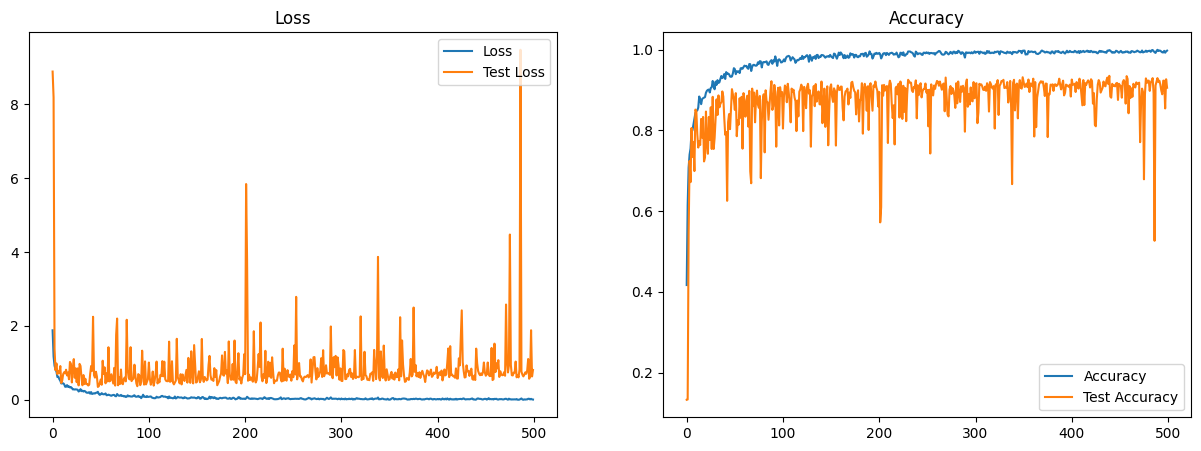

In [21]:
show_final_history(history)

The model is yet to reach the global minimum yet. At least the model is not overfitting which is a good thing. But its too bumpy, may need to change the momentum and learning rate for the optimizer.

# Plotting a Confusion Matrix

A confusion matrix is plotted below to see how well the model fared with respect to the train dataset. It will allow one to realize towards which class is the model biased against.

A threshold is set at half of the maximum correlation. Above that values are shown in white while below that are shown in black.

Bluer the shade of the block stronger the correlation between the predicted value and actual value. This type of matrix can also be shown for train data to show how the model fared there.

The model can be changed using this confusion matrix as a base calculation.

In [22]:
class_name_labels

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [23]:
y_test = np.argmax(y_val,axis=1)
y_test.shape,validation_generator.n

((1425,), 1425)

In [24]:
val_pred = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in val_pred]

C:\Users\soumi\AppData\Local\Temp\ipykernel_9076\4054254903.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  val_pred = model.predict_generator(generator=validation_generator)


In [25]:
y_pred = np.argmax(val_pred,axis=1)
y_pred.shape

(1425,)

<Figure size 640x480 with 0 Axes>

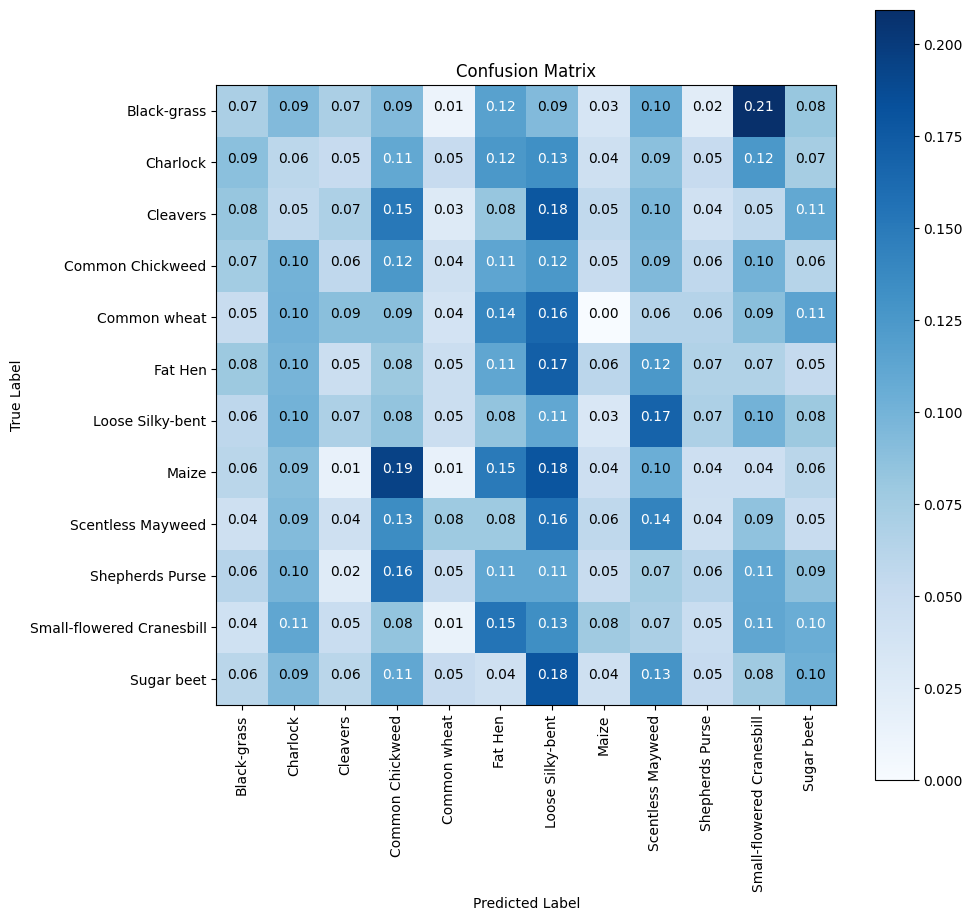

In [26]:
import itertools

def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)


plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.show()

The model is biased towards *Loose Silky Bent*

# Predicting the Test Images and making a submission

The test images are preprocessed via ImageDataGenerator and passed to the predict_generator function of the model for prediction. 

In [27]:
test_dir = ["./data/plant-seedlings-classification/test"]

def load_test():
    
    images,names = [],[]
    for dataset in test_dir:

        for file in tqdm(os.listdir(dataset)):
            
            img_path = os.path.join(dataset,file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(150,150))

            images.append(img)
            names.append(file)
            pass
        
        images = np.array(images,dtype=np.float32)
        pass
    
    return images,names
    pass

In [28]:
(test_images),(test_names) = load_test()

100%|███████████████████████████████████████████████████████████████████████████████| 794/794 [00:02<00:00, 328.82it/s]


In [29]:
for (label),(i) in class_name_labels.items():
    print(label,i)

Black-grass 0
Charlock 1
Cleavers 2
Common Chickweed 3
Common wheat 4
Fat Hen 5
Loose Silky-bent 6
Maize 7
Scentless Mayweed 8
Shepherds Purse 9
Small-flowered Cranesbill 10
Sugar beet 11


In [30]:
test_images[0].shape

(150, 150, 3)

In [31]:
from tensorflow.keras.utils import img_to_array

predicted_class = []
class_labels = dict((i,label) for label,i in class_name_labels.items())
for image in tqdm(test_images):
    
    image = np.expand_dims(image, axis=0)
    test_result = model.predict(image)
    pred_class = np.argmax(test_result,axis=1)
    prediction = [class_labels[k] for k in pred_class][0]
    predicted_class.append(prediction)
    pass

results = pd.DataFrame({"file":test_names,
                        "species":predicted_class})

  0%|                                                                                          | 0/794 [00:00<?, ?it/s]

1/1 [==============================] - 0s 135ms/step


  0%|                                                                                  | 1/794 [00:00<02:44,  4.82it/s]

1/1 [==============================] - 0s 11ms/step


  0%|▎                                                                                 | 3/794 [00:00<01:22,  9.60it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▌                                                                                 | 5/794 [00:00<01:06, 11.92it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▋                                                                                 | 7/794 [00:00<01:02, 12.53it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▉                                                                                 | 9/794 [00:00<00:59, 13.13it/s]

1/1 [==============================] - 0s 21ms/step


  1%|█                                                                                | 11/794 [00:00<00:58, 13.35it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▎                                                                               | 13/794 [00:01<01:00, 12.89it/s]

1/1 [==============================] - 0s 19ms/step


  2%|█▌                                                                               | 15/794 [00:01<00:59, 13.04it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▋                                                                               | 17/794 [00:01<01:01, 12.65it/s]

1/1 [==============================] - 0s 22ms/step


  2%|█▉                                                                               | 19/794 [00:01<01:00, 12.91it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▏                                                                              | 21/794 [00:01<01:01, 12.51it/s]

1/1 [==============================] - 0s 16ms/step


  3%|██▎                                                                              | 23/794 [00:01<01:01, 12.44it/s]

1/1 [==============================] - 0s 19ms/step


  3%|██▌                                                                              | 25/794 [00:02<01:00, 12.72it/s]

1/1 [==============================] - 0s 17ms/step


  3%|██▊                                                                              | 27/794 [00:02<01:01, 12.54it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▉                                                                              | 29/794 [00:02<00:59, 12.77it/s]

1/1 [==============================] - 0s 19ms/step


  4%|███▏                                                                             | 31/794 [00:02<01:00, 12.55it/s]

1/1 [==============================] - 0s 10ms/step


  4%|███▎                                                                             | 33/794 [00:02<01:00, 12.63it/s]

1/1 [==============================] - 0s 6ms/step


  4%|███▌                                                                             | 35/794 [00:02<00:58, 13.01it/s]

1/1 [==============================] - 0s 27ms/step


  5%|███▊                                                                             | 37/794 [00:02<00:59, 12.66it/s]

1/1 [==============================] - 0s 20ms/step


  5%|███▉                                                                             | 39/794 [00:03<01:00, 12.57it/s]

1/1 [==============================] - 0s 19ms/step


  5%|████▏                                                                            | 41/794 [00:03<00:58, 12.81it/s]

1/1 [==============================] - 0s 14ms/step


  5%|████▍                                                                            | 43/794 [00:03<00:58, 12.78it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▌                                                                            | 45/794 [00:03<00:57, 12.94it/s]

1/1 [==============================] - 0s 20ms/step


  6%|████▊                                                                            | 47/794 [00:03<00:57, 12.96it/s]

1/1 [==============================] - 0s 5ms/step


  6%|████▉                                                                            | 49/794 [00:03<00:57, 12.93it/s]

1/1 [==============================] - 0s 16ms/step


  6%|█████▏                                                                           | 51/794 [00:04<00:57, 12.94it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▍                                                                           | 53/794 [00:04<00:57, 12.97it/s]

1/1 [==============================] - 0s 9ms/step


  7%|█████▌                                                                           | 55/794 [00:04<00:56, 13.11it/s]

1/1 [==============================] - 0s 7ms/step


  7%|█████▊                                                                           | 57/794 [00:04<00:55, 13.17it/s]

1/1 [==============================] - 0s 19ms/step


  7%|██████                                                                           | 59/794 [00:04<00:55, 13.22it/s]

1/1 [==============================] - 0s 9ms/step


  8%|██████▏                                                                          | 61/794 [00:04<00:57, 12.84it/s]

1/1 [==============================] - 0s 22ms/step


  8%|██████▍                                                                          | 63/794 [00:04<00:58, 12.59it/s]

1/1 [==============================] - 0s 15ms/step


  8%|██████▋                                                                          | 65/794 [00:05<00:57, 12.76it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▊                                                                          | 67/794 [00:05<00:56, 12.92it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████                                                                          | 69/794 [00:05<00:55, 13.08it/s]

1/1 [==============================] - 0s 20ms/step


  9%|███████▏                                                                         | 71/794 [00:05<00:51, 14.01it/s]

1/1 [==============================] - 0s 20ms/step


  9%|███████▍                                                                         | 73/794 [00:05<00:50, 14.38it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███████▋                                                                         | 75/794 [00:05<00:49, 14.53it/s]

1/1 [==============================] - 0s 23ms/step


 10%|███████▊                                                                         | 77/794 [00:05<00:48, 14.72it/s]

1/1 [==============================] - 0s 20ms/step


 10%|████████                                                                         | 79/794 [00:06<00:46, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 10%|████████▎                                                                        | 81/794 [00:06<00:45, 15.69it/s]

1/1 [==============================] - 0s 20ms/step


 10%|████████▍                                                                        | 83/794 [00:06<00:45, 15.65it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▋                                                                        | 85/794 [00:06<00:45, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 11%|████████▉                                                                        | 87/794 [00:06<00:46, 15.32it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█████████                                                                        | 89/794 [00:06<00:46, 15.21it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█████████▎                                                                       | 91/794 [00:06<00:46, 15.16it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█████████▍                                                                       | 93/794 [00:06<00:46, 15.11it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█████████▋                                                                       | 95/794 [00:07<00:46, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█████████▉                                                                       | 97/794 [00:07<00:46, 15.15it/s]

1/1 [==============================] - 0s 16ms/step


 12%|██████████                                                                       | 99/794 [00:07<00:47, 14.52it/s]

1/1 [==============================] - 0s 9ms/step


 13%|██████████▏                                                                     | 101/794 [00:07<00:49, 13.97it/s]

1/1 [==============================] - 0s 9ms/step


 13%|██████████▍                                                                     | 103/794 [00:07<00:50, 13.78it/s]

1/1 [==============================] - 0s 6ms/step


 13%|██████████▌                                                                     | 105/794 [00:07<00:50, 13.77it/s]

1/1 [==============================] - 0s 20ms/step


 13%|██████████▊                                                                     | 107/794 [00:08<00:51, 13.46it/s]

1/1 [==============================] - 0s 17ms/step


 14%|██████████▉                                                                     | 109/794 [00:08<00:51, 13.27it/s]

1/1 [==============================] - 0s 18ms/step


 14%|███████████▏                                                                    | 111/794 [00:08<00:51, 13.22it/s]

1/1 [==============================] - 0s 11ms/step


 14%|███████████▍                                                                    | 113/794 [00:08<00:51, 13.13it/s]

1/1 [==============================] - 0s 21ms/step


 14%|███████████▌                                                                    | 115/794 [00:08<00:51, 13.28it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▊                                                                    | 117/794 [00:08<00:52, 12.86it/s]

1/1 [==============================] - 0s 17ms/step


 15%|███████████▉                                                                    | 119/794 [00:08<00:51, 13.00it/s]

1/1 [==============================] - 0s 5ms/step


 15%|████████████▏                                                                   | 121/794 [00:09<00:51, 13.11it/s]

1/1 [==============================] - 0s 18ms/step


 15%|████████████▍                                                                   | 123/794 [00:09<00:50, 13.18it/s]

1/1 [==============================] - 0s 17ms/step


 16%|████████████▌                                                                   | 125/794 [00:09<00:50, 13.23it/s]

1/1 [==============================] - 0s 17ms/step


 16%|████████████▊                                                                   | 127/794 [00:09<00:50, 13.26it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▉                                                                   | 129/794 [00:09<00:51, 12.83it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█████████████▏                                                                  | 131/794 [00:09<00:51, 12.97it/s]

1/1 [==============================] - 0s 9ms/step


 17%|█████████████▍                                                                  | 133/794 [00:10<00:50, 13.02it/s]

1/1 [==============================] - 0s 10ms/step


 17%|█████████████▌                                                                  | 135/794 [00:10<00:48, 13.66it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█████████████▊                                                                  | 137/794 [00:10<00:45, 14.47it/s]

1/1 [==============================] - 0s 20ms/step


 18%|██████████████                                                                  | 139/794 [00:10<00:44, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 18%|██████████████▏                                                                 | 141/794 [00:10<00:42, 15.38it/s]

1/1 [==============================] - 0s 21ms/step


 18%|██████████████▍                                                                 | 143/794 [00:10<00:41, 15.75it/s]

1/1 [==============================] - 0s 18ms/step


 18%|██████████████▌                                                                 | 145/794 [00:10<00:41, 15.71it/s]

1/1 [==============================] - 0s 20ms/step


 19%|██████████████▊                                                                 | 147/794 [00:10<00:40, 16.05it/s]

1/1 [==============================] - 0s 21ms/step


 19%|███████████████                                                                 | 149/794 [00:10<00:39, 16.23it/s]

1/1 [==============================] - 0s 19ms/step


 19%|███████████████▏                                                                | 151/794 [00:11<00:40, 15.97it/s]

1/1 [==============================] - 0s 20ms/step


 19%|███████████████▍                                                                | 153/794 [00:11<00:39, 16.18it/s]

1/1 [==============================] - 0s 20ms/step


 20%|███████████████▌                                                                | 155/794 [00:11<00:40, 15.94it/s]

1/1 [==============================] - 0s 20ms/step


 20%|███████████████▊                                                                | 157/794 [00:11<00:39, 16.20it/s]

1/1 [==============================] - 0s 15ms/step


 20%|████████████████                                                                | 159/794 [00:11<00:39, 15.89it/s]

1/1 [==============================] - 0s 21ms/step


 20%|████████████████▏                                                               | 161/794 [00:11<00:38, 16.25it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████████████▍                                                               | 163/794 [00:11<00:39, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


 21%|████████████████▌                                                               | 165/794 [00:12<00:41, 15.04it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████████████▊                                                               | 167/794 [00:12<00:45, 13.91it/s]

1/1 [==============================] - 0s 9ms/step


 21%|█████████████████                                                               | 169/794 [00:12<00:45, 13.79it/s]

1/1 [==============================] - 0s 22ms/step


 22%|█████████████████▏                                                              | 171/794 [00:12<00:45, 13.67it/s]

1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▍                                                              | 173/794 [00:12<00:47, 13.07it/s]

1/1 [==============================] - 0s 20ms/step


 22%|█████████████████▋                                                              | 175/794 [00:12<00:46, 13.20it/s]

1/1 [==============================] - 0s 17ms/step


 22%|█████████████████▊                                                              | 177/794 [00:12<00:46, 13.25it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██████████████████                                                              | 179/794 [00:13<00:47, 12.82it/s]

1/1 [==============================] - 0s 10ms/step


 23%|██████████████████▏                                                             | 181/794 [00:13<00:47, 12.93it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▍                                                             | 183/794 [00:13<00:46, 13.08it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▋                                                             | 185/794 [00:13<00:46, 13.14it/s]

1/1 [==============================] - 0s 8ms/step


 24%|██████████████████▊                                                             | 187/794 [00:13<00:45, 13.25it/s]

1/1 [==============================] - 0s 8ms/step


 24%|███████████████████                                                             | 189/794 [00:13<00:45, 13.30it/s]

1/1 [==============================] - 0s 9ms/step


 24%|███████████████████▏                                                            | 191/794 [00:14<00:45, 13.28it/s]

1/1 [==============================] - 0s 20ms/step


 24%|███████████████████▍                                                            | 193/794 [00:14<00:43, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


 25%|███████████████████▋                                                            | 195/794 [00:14<00:42, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 25%|███████████████████▊                                                            | 197/794 [00:14<00:39, 14.95it/s]

1/1 [==============================] - 0s 19ms/step


 25%|████████████████████                                                            | 199/794 [00:14<00:39, 15.06it/s]

1/1 [==============================] - 0s 20ms/step


 25%|████████████████████▎                                                           | 201/794 [00:14<00:38, 15.53it/s]

1/1 [==============================] - 0s 20ms/step


 26%|████████████████████▍                                                           | 203/794 [00:14<00:37, 15.80it/s]

1/1 [==============================] - 0s 20ms/step


 26%|████████████████████▋                                                           | 205/794 [00:14<00:37, 15.74it/s]

1/1 [==============================] - 0s 20ms/step


 26%|████████████████████▊                                                           | 207/794 [00:15<00:36, 16.03it/s]

1/1 [==============================] - 0s 19ms/step


 26%|█████████████████████                                                           | 209/794 [00:15<00:35, 16.34it/s]

1/1 [==============================] - 0s 19ms/step


 27%|█████████████████████▎                                                          | 211/794 [00:15<00:35, 16.49it/s]

1/1 [==============================] - 0s 16ms/step


 27%|█████████████████████▍                                                          | 213/794 [00:15<00:35, 16.25it/s]

1/1 [==============================] - 0s 20ms/step


 27%|█████████████████████▋                                                          | 215/794 [00:15<00:35, 16.42it/s]

1/1 [==============================] - 0s 19ms/step


 27%|█████████████████████▊                                                          | 217/794 [00:15<00:34, 16.51it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██████████████████████                                                          | 219/794 [00:15<00:35, 16.20it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██████████████████████▎                                                         | 221/794 [00:15<00:34, 16.38it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██████████████████████▍                                                         | 223/794 [00:16<00:38, 14.94it/s]

1/1 [==============================] - 0s 8ms/step


 28%|██████████████████████▋                                                         | 225/794 [00:16<00:39, 14.34it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██████████████████████▊                                                         | 227/794 [00:16<00:41, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 29%|███████████████████████                                                         | 229/794 [00:16<00:41, 13.47it/s]

1/1 [==============================] - 0s 12ms/step


 29%|███████████████████████▎                                                        | 231/794 [00:16<00:43, 12.99it/s]

1/1 [==============================] - 0s 18ms/step


 29%|███████████████████████▍                                                        | 233/794 [00:16<00:43, 12.94it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▋                                                        | 235/794 [00:16<00:43, 12.77it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███████████████████████▉                                                        | 237/794 [00:17<00:43, 12.88it/s]

1/1 [==============================] - 0s 9ms/step


 30%|████████████████████████                                                        | 239/794 [00:17<00:42, 13.00it/s]

1/1 [==============================] - 0s 5ms/step


 30%|████████████████████████▎                                                       | 241/794 [00:17<00:41, 13.21it/s]

1/1 [==============================] - 0s 18ms/step


 31%|████████████████████████▍                                                       | 243/794 [00:17<00:41, 13.25it/s]

1/1 [==============================] - 0s 14ms/step


 31%|████████████████████████▋                                                       | 245/794 [00:17<00:42, 12.84it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▉                                                       | 247/794 [00:17<00:42, 12.97it/s]

1/1 [==============================] - 0s 20ms/step


 31%|█████████████████████████                                                       | 249/794 [00:18<00:41, 13.11it/s]

1/1 [==============================] - 0s 8ms/step


 32%|█████████████████████████▎                                                      | 251/794 [00:18<00:39, 13.66it/s]

1/1 [==============================] - 0s 16ms/step


 32%|█████████████████████████▍                                                      | 253/794 [00:18<00:38, 14.04it/s]

1/1 [==============================] - 0s 18ms/step


 32%|█████████████████████████▋                                                      | 255/794 [00:18<00:36, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 32%|█████████████████████████▉                                                      | 257/794 [00:18<00:35, 14.94it/s]

1/1 [==============================] - 0s 20ms/step


 33%|██████████████████████████                                                      | 259/794 [00:18<00:34, 15.30it/s]

1/1 [==============================] - 0s 22ms/step


 33%|██████████████████████████▎                                                     | 261/794 [00:18<00:34, 15.36it/s]

1/1 [==============================] - 0s 11ms/step


 33%|██████████████████████████▍                                                     | 263/794 [00:18<00:34, 15.34it/s]

1/1 [==============================] - 0s 20ms/step


 33%|██████████████████████████▋                                                     | 265/794 [00:19<00:33, 15.78it/s]

1/1 [==============================] - 0s 20ms/step


 34%|██████████████████████████▉                                                     | 267/794 [00:19<00:33, 15.96it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███████████████████████████                                                     | 269/794 [00:19<00:33, 15.87it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███████████████████████████▎                                                    | 271/794 [00:19<00:32, 16.24it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███████████████████████████▌                                                    | 273/794 [00:19<00:32, 15.83it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███████████████████████████▋                                                    | 275/794 [00:19<00:32, 16.21it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███████████████████████████▉                                                    | 277/794 [00:19<00:31, 16.50it/s]

1/1 [==============================] - 0s 17ms/step


 35%|████████████████████████████                                                    | 279/794 [00:19<00:32, 16.01it/s]

1/1 [==============================] - 0s 11ms/step


 35%|████████████████████████████▎                                                   | 281/794 [00:20<00:34, 15.00it/s]

1/1 [==============================] - 0s 5ms/step


 36%|████████████████████████████▌                                                   | 283/794 [00:20<00:35, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


 36%|████████████████████████████▋                                                   | 285/794 [00:20<00:35, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 36%|████████████████████████████▉                                                   | 287/794 [00:20<00:36, 13.96it/s]

1/1 [==============================] - 0s 13ms/step


 36%|█████████████████████████████                                                   | 289/794 [00:20<00:37, 13.32it/s]

1/1 [==============================] - 0s 14ms/step


 37%|█████████████████████████████▎                                                  | 291/794 [00:20<00:37, 13.31it/s]

1/1 [==============================] - 0s 8ms/step


 37%|█████████████████████████████▌                                                  | 293/794 [00:20<00:37, 13.32it/s]

1/1 [==============================] - 0s 8ms/step


 37%|█████████████████████████████▋                                                  | 295/794 [00:21<00:37, 13.34it/s]

1/1 [==============================] - 0s 7ms/step


 37%|█████████████████████████████▉                                                  | 297/794 [00:21<00:36, 13.45it/s]

1/1 [==============================] - 0s 7ms/step


 38%|██████████████████████████████▏                                                 | 299/794 [00:21<00:37, 13.31it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████████████████████▎                                                 | 301/794 [00:21<00:36, 13.33it/s]

1/1 [==============================] - 0s 20ms/step


 38%|██████████████████████████████▌                                                 | 303/794 [00:21<00:36, 13.33it/s]

1/1 [==============================] - 0s 17ms/step


 38%|██████████████████████████████▋                                                 | 305/794 [00:21<00:36, 13.33it/s]

1/1 [==============================] - 0s 18ms/step


 39%|██████████████████████████████▉                                                 | 307/794 [00:22<00:36, 13.34it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████████████████████▏                                                | 309/794 [00:22<00:37, 12.92it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███████████████████████████████▎                                                | 311/794 [00:22<00:37, 12.93it/s]

1/1 [==============================] - 0s 6ms/step


 39%|███████████████████████████████▌                                                | 313/794 [00:22<00:36, 13.29it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███████████████████████████████▋                                                | 315/794 [00:22<00:36, 13.16it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███████████████████████████████▉                                                | 317/794 [00:22<00:35, 13.31it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████████████████████████████████▏                                               | 319/794 [00:22<00:33, 14.14it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████████████████████████████████▎                                               | 321/794 [00:23<00:31, 14.83it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████████████████████████████████▌                                               | 323/794 [00:23<00:31, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████████████████████████████████▋                                               | 325/794 [00:23<00:31, 15.10it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████████████████████▉                                               | 327/794 [00:23<00:31, 15.00it/s]

1/1 [==============================] - 0s 21ms/step


 41%|█████████████████████████████████▏                                              | 329/794 [00:23<00:29, 15.55it/s]

1/1 [==============================] - 0s 20ms/step


 42%|█████████████████████████████████▎                                              | 331/794 [00:23<00:30, 15.42it/s]

1/1 [==============================] - 0s 24ms/step


 42%|█████████████████████████████████▌                                              | 333/794 [00:23<00:29, 15.75it/s]

1/1 [==============================] - 0s 21ms/step


 42%|█████████████████████████████████▊                                              | 335/794 [00:23<00:29, 15.62it/s]

1/1 [==============================] - 0s 20ms/step


 42%|█████████████████████████████████▉                                              | 337/794 [00:24<00:29, 15.48it/s]

1/1 [==============================] - 0s 20ms/step


 43%|██████████████████████████████████▏                                             | 339/794 [00:24<00:29, 15.38it/s]

1/1 [==============================] - 0s 33ms/step


 43%|██████████████████████████████████▎                                             | 341/794 [00:24<00:29, 15.34it/s]

1/1 [==============================] - 0s 20ms/step


 43%|██████████████████████████████████▌                                             | 343/794 [00:24<00:29, 15.21it/s]

1/1 [==============================] - 0s 24ms/step


 43%|██████████████████████████████████▊                                             | 345/794 [00:24<00:29, 15.07it/s]

1/1 [==============================] - 0s 20ms/step


 44%|██████████████████████████████████▉                                             | 347/794 [00:24<00:30, 14.50it/s]

1/1 [==============================] - 0s 9ms/step


 44%|███████████████████████████████████▏                                            | 349/794 [00:24<00:32, 13.58it/s]

1/1 [==============================] - 0s 5ms/step


 44%|███████████████████████████████████▎                                            | 351/794 [00:25<00:32, 13.58it/s]

1/1 [==============================] - 0s 18ms/step


 44%|███████████████████████████████████▌                                            | 353/794 [00:25<00:32, 13.44it/s]

1/1 [==============================] - 0s 17ms/step


 45%|███████████████████████████████████▊                                            | 355/794 [00:25<00:33, 13.13it/s]

1/1 [==============================] - 0s 17ms/step


 45%|███████████████████████████████████▉                                            | 357/794 [00:25<00:33, 13.18it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████████████████████████████████████▏                                           | 359/794 [00:25<00:33, 13.14it/s]

1/1 [==============================] - 0s 10ms/step


 45%|████████████████████████████████████▎                                           | 361/794 [00:25<00:32, 13.29it/s]

1/1 [==============================] - 0s 9ms/step


 46%|████████████████████████████████████▌                                           | 363/794 [00:25<00:32, 13.23it/s]

1/1 [==============================] - 0s 8ms/step


 46%|████████████████████████████████████▊                                           | 365/794 [00:26<00:32, 13.36it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████████████████████████████████████▉                                           | 367/794 [00:26<00:32, 13.26it/s]

1/1 [==============================] - 0s 16ms/step


 46%|█████████████████████████████████████▏                                          | 369/794 [00:26<00:32, 12.89it/s]

1/1 [==============================] - 0s 13ms/step


 47%|█████████████████████████████████████▍                                          | 371/794 [00:26<00:32, 12.95it/s]

1/1 [==============================] - 0s 22ms/step


 47%|█████████████████████████████████████▌                                          | 373/794 [00:26<00:32, 13.11it/s]

1/1 [==============================] - 0s 20ms/step


 47%|█████████████████████████████████████▊                                          | 375/794 [00:26<00:31, 13.19it/s]

1/1 [==============================] - 0s 10ms/step


 47%|█████████████████████████████████████▉                                          | 377/794 [00:27<00:32, 12.90it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████████████████████████▏                                         | 379/794 [00:27<00:32, 12.61it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████████████████████████▍                                         | 381/794 [00:27<00:32, 12.82it/s]

1/1 [==============================] - 0s 15ms/step


 48%|██████████████████████████████████████▌                                         | 383/794 [00:27<00:31, 12.91it/s]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████████████████████████▊                                         | 385/794 [00:27<00:31, 13.08it/s]

1/1 [==============================] - 0s 17ms/step


 49%|██████████████████████████████████████▉                                         | 387/794 [00:27<00:30, 13.32it/s]

1/1 [==============================] - 0s 10ms/step


 49%|███████████████████████████████████████▏                                        | 389/794 [00:28<00:38, 10.61it/s]

1/1 [==============================] - 0s 19ms/step


 49%|███████████████████████████████████████▍                                        | 391/794 [00:28<00:35, 11.36it/s]

1/1 [==============================] - 0s 8ms/step


 49%|███████████████████████████████████████▌                                        | 393/794 [00:28<00:33, 11.90it/s]

1/1 [==============================] - 0s 8ms/step


 50%|███████████████████████████████████████▊                                        | 395/794 [00:28<00:32, 12.29it/s]

1/1 [==============================] - 0s 7ms/step


 50%|████████████████████████████████████████                                        | 397/794 [00:28<00:31, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████████████████████████████████████████▏                                       | 399/794 [00:28<00:29, 13.31it/s]

1/1 [==============================] - 0s 18ms/step


 51%|████████████████████████████████████████▍                                       | 401/794 [00:28<00:28, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 51%|████████████████████████████████████████▌                                       | 403/794 [00:29<00:26, 14.55it/s]

1/1 [==============================] - 0s 21ms/step


 51%|████████████████████████████████████████▊                                       | 405/794 [00:29<00:25, 15.12it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████████████████████████████████████████                                       | 407/794 [00:29<00:25, 15.28it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████████████████████████████████████████▏                                      | 409/794 [00:29<00:25, 15.11it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████████████████████████████████████████▍                                      | 411/794 [00:29<00:25, 15.18it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████████████████████████▌                                      | 413/794 [00:29<00:25, 15.22it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████████████████████████▊                                      | 415/794 [00:29<00:24, 15.43it/s]

1/1 [==============================] - 0s 22ms/step


 53%|██████████████████████████████████████████                                      | 417/794 [00:29<00:24, 15.48it/s]

1/1 [==============================] - 0s 20ms/step


 53%|██████████████████████████████████████████▏                                     | 419/794 [00:30<00:23, 15.90it/s]

1/1 [==============================] - 0s 22ms/step


 53%|██████████████████████████████████████████▍                                     | 421/794 [00:30<00:23, 16.13it/s]

1/1 [==============================] - 0s 21ms/step


 53%|██████████████████████████████████████████▌                                     | 423/794 [00:30<00:23, 15.88it/s]

1/1 [==============================] - 0s 20ms/step


 54%|██████████████████████████████████████████▊                                     | 425/794 [00:30<00:22, 16.24it/s]

1/1 [==============================] - 0s 21ms/step


 54%|███████████████████████████████████████████                                     | 427/794 [00:30<00:22, 16.38it/s]

1/1 [==============================] - 0s 16ms/step


 54%|███████████████████████████████████████████▏                                    | 429/794 [00:30<00:24, 14.94it/s]

1/1 [==============================] - 0s 13ms/step


 54%|███████████████████████████████████████████▍                                    | 431/794 [00:30<00:25, 14.37it/s]

1/1 [==============================] - 0s 10ms/step


 55%|███████████████████████████████████████████▋                                    | 433/794 [00:31<00:25, 14.04it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████▊                                    | 435/794 [00:31<00:26, 13.38it/s]

1/1 [==============================] - 0s 22ms/step


 55%|████████████████████████████████████████████                                    | 437/794 [00:31<00:26, 13.37it/s]

1/1 [==============================] - 0s 14ms/step


 55%|████████████████████████████████████████████▏                                   | 439/794 [00:31<00:27, 12.89it/s]

1/1 [==============================] - 0s 10ms/step


 56%|████████████████████████████████████████████▍                                   | 441/794 [00:31<00:27, 13.06it/s]

1/1 [==============================] - 0s 6ms/step


 56%|████████████████████████████████████████████▋                                   | 443/794 [00:31<00:26, 13.19it/s]

1/1 [==============================] - 0s 19ms/step


 56%|████████████████████████████████████████████▊                                   | 445/794 [00:31<00:26, 13.19it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████████████████████████████████████████████                                   | 447/794 [00:32<00:26, 12.89it/s]

1/1 [==============================] - 0s 14ms/step


 57%|█████████████████████████████████████████████▏                                  | 449/794 [00:32<00:26, 12.94it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████████████████████████████████████████████▍                                  | 451/794 [00:32<00:26, 13.08it/s]

1/1 [==============================] - 0s 10ms/step


 57%|█████████████████████████████████████████████▋                                  | 453/794 [00:32<00:26, 13.07it/s]

1/1 [==============================] - 0s 8ms/step


 57%|█████████████████████████████████████████████▊                                  | 455/794 [00:32<00:25, 13.21it/s]

1/1 [==============================] - 0s 20ms/step


 58%|██████████████████████████████████████████████                                  | 457/794 [00:32<00:25, 13.27it/s]

1/1 [==============================] - 0s 6ms/step


 58%|██████████████████████████████████████████████▏                                 | 459/794 [00:33<00:25, 13.29it/s]

1/1 [==============================] - 0s 21ms/step


 58%|██████████████████████████████████████████████▍                                 | 461/794 [00:33<00:25, 13.31it/s]

1/1 [==============================] - 0s 15ms/step


 58%|██████████████████████████████████████████████▋                                 | 463/794 [00:33<00:24, 13.69it/s]

1/1 [==============================] - 0s 19ms/step


 59%|██████████████████████████████████████████████▊                                 | 465/794 [00:33<00:23, 14.15it/s]

1/1 [==============================] - 0s 19ms/step


 59%|███████████████████████████████████████████████                                 | 467/794 [00:33<00:21, 14.93it/s]

1/1 [==============================] - 0s 21ms/step


 59%|███████████████████████████████████████████████▎                                | 469/794 [00:33<00:21, 15.33it/s]

1/1 [==============================] - 0s 20ms/step


 59%|███████████████████████████████████████████████▍                                | 471/794 [00:33<00:21, 15.38it/s]

1/1 [==============================] - 0s 20ms/step


 60%|███████████████████████████████████████████████▋                                | 473/794 [00:33<00:20, 15.86it/s]

1/1 [==============================] - 0s 16ms/step


 60%|███████████████████████████████████████████████▊                                | 475/794 [00:34<00:20, 15.73it/s]

1/1 [==============================] - 0s 20ms/step


 60%|████████████████████████████████████████████████                                | 477/794 [00:34<00:19, 16.07it/s]

1/1 [==============================] - 0s 20ms/step


 60%|████████████████████████████████████████████████▎                               | 479/794 [00:34<00:19, 16.39it/s]

1/1 [==============================] - 0s 17ms/step


 61%|████████████████████████████████████████████████▍                               | 481/794 [00:34<00:19, 16.03it/s]

1/1 [==============================] - 0s 18ms/step


 61%|████████████████████████████████████████████████▋                               | 483/794 [00:34<00:19, 15.62it/s]

1/1 [==============================] - 0s 17ms/step


 61%|████████████████████████████████████████████████▊                               | 485/794 [00:34<00:20, 15.43it/s]

1/1 [==============================] - 0s 21ms/step


 61%|█████████████████████████████████████████████████                               | 487/794 [00:34<00:19, 15.74it/s]

1/1 [==============================] - 0s 21ms/step


 62%|█████████████████████████████████████████████████▎                              | 489/794 [00:34<00:19, 15.70it/s]

1/1 [==============================] - 0s 20ms/step


 62%|█████████████████████████████████████████████████▍                              | 491/794 [00:35<00:20, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 62%|█████████████████████████████████████████████████▋                              | 493/794 [00:35<00:20, 14.40it/s]

1/1 [==============================] - 0s 17ms/step


 62%|█████████████████████████████████████████████████▊                              | 495/794 [00:35<00:21, 14.06it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████████████████████████████████████████████████                              | 497/794 [00:35<00:22, 13.40it/s]

1/1 [==============================] - 0s 10ms/step


 63%|██████████████████████████████████████████████████▎                             | 499/794 [00:35<00:22, 13.30it/s]

1/1 [==============================] - 0s 8ms/step


 63%|██████████████████████████████████████████████████▍                             | 501/794 [00:35<00:21, 13.49it/s]

1/1 [==============================] - 0s 5ms/step


 63%|██████████████████████████████████████████████████▋                             | 503/794 [00:36<00:22, 13.16it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████████████████████████████████████████████████▉                             | 505/794 [00:36<00:21, 13.38it/s]

1/1 [==============================] - 0s 14ms/step


 64%|███████████████████████████████████████████████████                             | 507/794 [00:36<00:22, 12.98it/s]

1/1 [==============================] - 0s 14ms/step


 64%|███████████████████████████████████████████████████▎                            | 509/794 [00:36<00:21, 13.02it/s]

1/1 [==============================] - 0s 6ms/step


 64%|███████████████████████████████████████████████████▍                            | 511/794 [00:36<00:21, 13.15it/s]

1/1 [==============================] - 0s 6ms/step


 65%|███████████████████████████████████████████████████▋                            | 513/794 [00:36<00:21, 13.20it/s]

1/1 [==============================] - 0s 8ms/step


 65%|███████████████████████████████████████████████████▉                            | 515/794 [00:36<00:20, 13.37it/s]

1/1 [==============================] - 0s 21ms/step


 65%|████████████████████████████████████████████████████                            | 517/794 [00:37<00:20, 13.24it/s]

1/1 [==============================] - 0s 20ms/step


 65%|████████████████████████████████████████████████████▎                           | 519/794 [00:37<00:20, 13.27it/s]

1/1 [==============================] - 0s 14ms/step


 66%|████████████████████████████████████████████████████▍                           | 521/794 [00:37<00:21, 12.91it/s]

1/1 [==============================] - 0s 20ms/step


 66%|████████████████████████████████████████████████████▋                           | 523/794 [00:37<00:19, 13.89it/s]

1/1 [==============================] - 0s 19ms/step


 66%|████████████████████████████████████████████████████▉                           | 525/794 [00:37<00:18, 14.74it/s]

1/1 [==============================] - 0s 20ms/step


 66%|█████████████████████████████████████████████████████                           | 527/794 [00:37<00:17, 15.36it/s]

1/1 [==============================] - 0s 15ms/step


 67%|█████████████████████████████████████████████████████▎                          | 529/794 [00:37<00:17, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 67%|█████████████████████████████████████████████████████▌                          | 531/794 [00:38<00:16, 15.78it/s]

1/1 [==============================] - 0s 20ms/step


 67%|█████████████████████████████████████████████████████▋                          | 533/794 [00:38<00:16, 16.15it/s]

1/1 [==============================] - 0s 18ms/step


 67%|█████████████████████████████████████████████████████▉                          | 535/794 [00:38<00:15, 16.28it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████████████████████████████████████████████████████                          | 537/794 [00:38<00:16, 16.05it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████████████████████████████████████████████████████▎                         | 539/794 [00:38<00:15, 16.12it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████████████████████████████████████████████████████▌                         | 541/794 [00:38<00:15, 16.01it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████████████████████████████████████████████████████▋                         | 543/794 [00:38<00:15, 15.81it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████████████████████████████████████████████████████▉                         | 545/794 [00:38<00:15, 16.08it/s]

1/1 [==============================] - 0s 21ms/step


 69%|███████████████████████████████████████████████████████                         | 547/794 [00:38<00:15, 16.22it/s]

1/1 [==============================] - 0s 22ms/step


 69%|███████████████████████████████████████████████████████▎                        | 549/794 [00:39<00:15, 15.98it/s]

1/1 [==============================] - 0s 20ms/step


 69%|███████████████████████████████████████████████████████▌                        | 551/794 [00:39<00:15, 15.70it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████████████████████████████████████████████████████▋                        | 553/794 [00:39<00:16, 14.30it/s]

1/1 [==============================] - 0s 10ms/step


 70%|███████████████████████████████████████████████████████▉                        | 555/794 [00:39<00:16, 14.16it/s]

1/1 [==============================] - 0s 19ms/step


 70%|████████████████████████████████████████████████████████                        | 557/794 [00:39<00:17, 13.82it/s]

1/1 [==============================] - 0s 15ms/step


 70%|████████████████████████████████████████████████████████▎                       | 559/794 [00:39<00:17, 13.26it/s]

1/1 [==============================] - 0s 16ms/step


 71%|████████████████████████████████████████████████████████▌                       | 561/794 [00:40<00:17, 13.33it/s]

1/1 [==============================] - 0s 15ms/step


 71%|████████████████████████████████████████████████████████▋                       | 563/794 [00:40<00:17, 13.35it/s]

1/1 [==============================] - 0s 11ms/step


 71%|████████████████████████████████████████████████████████▉                       | 565/794 [00:40<00:17, 13.23it/s]

1/1 [==============================] - 0s 10ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 567/794 [00:40<00:17, 13.28it/s]

1/1 [==============================] - 0s 7ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 569/794 [00:40<00:16, 13.38it/s]

1/1 [==============================] - 0s 8ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 571/794 [00:40<00:16, 13.20it/s]

1/1 [==============================] - 0s 8ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 573/794 [00:40<00:16, 13.33it/s]

1/1 [==============================] - 0s 8ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 575/794 [00:41<00:16, 13.45it/s]

1/1 [==============================] - 0s 17ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 577/794 [00:41<00:16, 13.30it/s]

1/1 [==============================] - 0s 18ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 579/794 [00:41<00:16, 13.32it/s]

1/1 [==============================] - 0s 18ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 581/794 [00:41<00:15, 13.33it/s]

1/1 [==============================] - 0s 17ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 583/794 [00:41<00:15, 13.33it/s]

1/1 [==============================] - 0s 17ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 585/794 [00:41<00:15, 13.34it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 587/794 [00:41<00:15, 13.71it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 589/794 [00:42<00:14, 14.57it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 591/794 [00:42<00:13, 14.82it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 593/794 [00:42<00:13, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 595/794 [00:42<00:12, 15.78it/s]

1/1 [==============================] - 0s 15ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 597/794 [00:42<00:13, 15.09it/s]

1/1 [==============================] - 0s 17ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 599/794 [00:42<00:12, 15.19it/s]

1/1 [==============================] - 0s 21ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 601/794 [00:42<00:12, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 603/794 [00:42<00:12, 15.50it/s]

1/1 [==============================] - 0s 20ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 605/794 [00:43<00:11, 15.86it/s]

1/1 [==============================] - 0s 15ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 607/794 [00:43<00:11, 15.60it/s]

1/1 [==============================] - 0s 20ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 609/794 [00:43<00:11, 15.58it/s]

1/1 [==============================] - 0s 21ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 611/794 [00:43<00:11, 15.41it/s]

1/1 [==============================] - 0s 23ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 613/794 [00:43<00:11, 15.73it/s]

1/1 [==============================] - 0s 17ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 615/794 [00:43<00:11, 14.94it/s]

1/1 [==============================] - 0s 10ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 617/794 [00:43<00:12, 13.87it/s]

1/1 [==============================] - 0s 10ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 619/794 [00:44<00:12, 13.71it/s]

1/1 [==============================] - 0s 10ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 621/794 [00:44<00:12, 13.61it/s]

1/1 [==============================] - 0s 13ms/step


 78%|██████████████████████████████████████████████████████████████▊                 | 623/794 [00:44<00:12, 13.57it/s]

1/1 [==============================] - 0s 9ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 625/794 [00:44<00:12, 13.42it/s]

1/1 [==============================] - 0s 7ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 627/794 [00:44<00:12, 13.60it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 629/794 [00:44<00:12, 13.31it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 631/794 [00:44<00:12, 13.40it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 633/794 [00:45<00:12, 13.30it/s]

1/1 [==============================] - 0s 10ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 635/794 [00:45<00:12, 12.97it/s]

1/1 [==============================] - 0s 6ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 637/794 [00:45<00:11, 13.09it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████████████████████████████████████████████████████████████▍               | 639/794 [00:45<00:12, 12.84it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 641/794 [00:45<00:11, 13.32it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 643/794 [00:45<00:11, 12.96it/s]

1/1 [==============================] - 0s 14ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 645/794 [00:46<00:11, 13.06it/s]

1/1 [==============================] - 0s 21ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 647/794 [00:46<00:10, 13.99it/s]

1/1 [==============================] - 0s 19ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 649/794 [00:46<00:10, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


 82%|█████████████████████████████████████████████████████████████████▌              | 651/794 [00:46<00:09, 14.81it/s]

1/1 [==============================] - 0s 14ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 653/794 [00:46<00:09, 15.06it/s]

1/1 [==============================] - 0s 18ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 655/794 [00:46<00:09, 15.10it/s]

1/1 [==============================] - 0s 20ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 657/794 [00:46<00:08, 15.53it/s]

1/1 [==============================] - 0s 13ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 659/794 [00:46<00:08, 15.45it/s]

1/1 [==============================] - 0s 20ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 661/794 [00:47<00:08, 15.93it/s]

1/1 [==============================] - 0s 20ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 663/794 [00:47<00:08, 16.15it/s]

1/1 [==============================] - 0s 15ms/step


 84%|███████████████████████████████████████████████████████████████████             | 665/794 [00:47<00:08, 16.01it/s]

1/1 [==============================] - 0s 20ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 667/794 [00:47<00:07, 16.24it/s]

1/1 [==============================] - 0s 19ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 669/794 [00:47<00:07, 16.52it/s]

1/1 [==============================] - 0s 18ms/step


 85%|███████████████████████████████████████████████████████████████████▌            | 671/794 [00:47<00:07, 16.15it/s]

1/1 [==============================] - 0s 21ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 673/794 [00:47<00:07, 16.31it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████████████████████████████████████████████████████████████████            | 675/794 [00:47<00:07, 15.57it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 677/794 [00:48<00:07, 14.71it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 679/794 [00:48<00:08, 14.36it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 681/794 [00:48<00:08, 13.92it/s]

1/1 [==============================] - 0s 9ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 683/794 [00:48<00:08, 13.66it/s]

1/1 [==============================] - 0s 19ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 685/794 [00:48<00:08, 13.57it/s]

1/1 [==============================] - 0s 13ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 687/794 [00:48<00:08, 13.06it/s]

1/1 [==============================] - 0s 17ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 689/794 [00:49<00:08, 12.78it/s]

1/1 [==============================] - 0s 12ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 691/794 [00:49<00:07, 12.89it/s]

1/1 [==============================] - 0s 10ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 693/794 [00:49<00:07, 13.02it/s]

1/1 [==============================] - 0s 11ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 695/794 [00:49<00:07, 13.12it/s]

1/1 [==============================] - 0s 10ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 697/794 [00:49<00:07, 13.18it/s]

1/1 [==============================] - 0s 8ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 699/794 [00:49<00:07, 13.23it/s]

1/1 [==============================] - 0s 10ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 701/794 [00:49<00:07, 13.27it/s]

1/1 [==============================] - 0s 5ms/step


 89%|██████████████████████████████████████████████████████████████████████▊         | 703/794 [00:50<00:06, 13.29it/s]

1/1 [==============================] - 0s 19ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 705/794 [00:50<00:06, 13.31it/s]

1/1 [==============================] - 0s 6ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 707/794 [00:50<00:06, 13.43it/s]

1/1 [==============================] - 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 709/794 [00:50<00:06, 13.29it/s]

1/1 [==============================] - 0s 5ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 711/794 [00:50<00:06, 13.30it/s]

1/1 [==============================] - 0s 19ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 713/794 [00:50<00:05, 13.90it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 715/794 [00:50<00:05, 14.60it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 717/794 [00:51<00:05, 15.19it/s]

1/1 [==============================] - 0s 20ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 719/794 [00:51<00:04, 15.27it/s]

1/1 [==============================] - 0s 21ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 721/794 [00:51<00:04, 15.60it/s]

1/1 [==============================] - 0s 21ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 723/794 [00:51<00:04, 16.12it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 725/794 [00:51<00:04, 16.33it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████████████████████████████████████████████████████████████████████▏      | 727/794 [00:51<00:04, 15.49it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 729/794 [00:51<00:04, 15.89it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 731/794 [00:51<00:04, 15.61it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 733/794 [00:52<00:03, 16.06it/s]

1/1 [==============================] - 0s 21ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 735/794 [00:52<00:03, 16.30it/s]

1/1 [==============================] - 0s 19ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 737/794 [00:52<00:03, 16.49it/s]

1/1 [==============================] - 0s 22ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 739/794 [00:52<00:03, 16.24it/s]

1/1 [==============================] - 0s 19ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 741/794 [00:52<00:03, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 743/794 [00:52<00:03, 14.95it/s]

1/1 [==============================] - 0s 16ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 745/794 [00:52<00:03, 14.05it/s]

1/1 [==============================] - 0s 16ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 747/794 [00:53<00:03, 13.82it/s]

1/1 [==============================] - 0s 10ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 749/794 [00:53<00:03, 13.56it/s]

1/1 [==============================] - 0s 19ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 751/794 [00:53<00:03, 13.50it/s]

1/1 [==============================] - 0s 19ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 753/794 [00:53<00:03, 13.45it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 755/794 [00:53<00:02, 13.05it/s]

1/1 [==============================] - 0s 16ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 757/794 [00:53<00:02, 13.17it/s]

1/1 [==============================] - 0s 15ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 759/794 [00:53<00:02, 13.18it/s]

1/1 [==============================] - 0s 16ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 761/794 [00:54<00:02, 13.17it/s]

1/1 [==============================] - 0s 10ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 763/794 [00:54<00:02, 13.22it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 765/794 [00:54<00:02, 13.76it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 767/794 [00:54<00:01, 14.58it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 769/794 [00:54<00:01, 14.81it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 771/794 [00:54<00:01, 15.11it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 773/794 [00:54<00:01, 15.26it/s]

1/1 [==============================] - 0s 20ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 775/794 [00:54<00:01, 15.65it/s]

1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 777/794 [00:55<00:01, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 779/794 [00:55<00:00, 15.95it/s]

1/1 [==============================] - 0s 21ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 781/794 [00:55<00:00, 15.84it/s]

1/1 [==============================] - 0s 21ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 783/794 [00:55<00:00, 16.06it/s]

1/1 [==============================] - 0s 20ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 785/794 [00:55<00:00, 16.30it/s]

1/1 [==============================] - 0s 20ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 787/794 [00:55<00:00, 16.07it/s]

1/1 [==============================] - 0s 20ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 789/794 [00:55<00:00, 16.14it/s]

1/1 [==============================] - 0s 21ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 791/794 [00:55<00:00, 16.43it/s]

1/1 [==============================] - 0s 23ms/step


100%|███████████████████████████████████████████████████████████████████████████████▉| 793/794 [00:56<00:00, 16.14it/s]

1/1 [==============================] - 0s 22ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 794/794 [00:56<00:00, 14.13it/s]


In [32]:
results.head()

,file,species
0,0021e90e4.png,Loose Silky-bent
1,003d61042.png,Loose Silky-bent
2,007b3da8b.png,Loose Silky-bent
3,0086a6340.png,Loose Silky-bent
4,00c47e980.png,Loose Silky-bent


In [33]:
results.to_csv("submission.csv",index=False)

In [34]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    pass